# Химическая кинетика 

Рассматорим систему ОДУ, описывающую поведение концентрации веществ в химических реакциях Белоусова-Жаботинского, которая имеет следующий вид:

$\frac{dy_1}{dt} = 77.27[y_2 + y_1(1 - 8.375\cdot 10^{-6}y_1 - y_2)]$

$\frac{dy_2}{dt} = \frac{1}{77.27}[y_3 - (1 + y_1)y_2]$

$\frac{dy_3}{dt} = 0.16(y_1 - y_3)$

$0 \le t \le 800, y_1(0) = 1, y_2(0) = 2, y_3(0) = 3$

Имеем дело с жесткой системой ОДУ. Будем решать ее используя явный и неявный методы Рунге-Кутта. Исследуем численное решение на сходимость по сетке, найдем погрешности метода.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
from scipy.optimize import fsolve
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

In [2]:
def f(u):
    y1, y2, y3 = u
    return [77.27 * (y2 + y1 * (1 - 8.375 * 1e-6 * y1 - y2)), 
            1 / 77.27 * (y3 - (1 + y1) * y2), 
            0.16 * (y1 - y3)]

### 1. Явный метод Рунге-Кутта

In [3]:
def rkk_rank4(n, h, st_point):
    point = st_point
    res = [st_point]
    for i in range(n-1):
        k1 = f(point)
        k2_arg = [point[i] + 0.5*h*k1[i] for i in range(len(point))]
        k2 = f(k2_arg)
        k3_arg = [point[i] + 0.5*h*k2[i] for i in range(len(point))]
        k3 = f(k3_arg)
        k4_arg = [point[i] + h*k3[i] for i in range(len(point))]
        k4 = f(k4_arg)
        next_point = [point[i] + h/6 * (k1[i]+2*k2[i]+2*k3[i]+k4[i]) for i in range(len(point))]
        res.append(next_point)
        point = next_point
    return res

In [4]:
T = 800
h = 1e-5
n = int(T/h)
st_point = [1, 2, 3]
table = rkk_rank4(n, h, st_point)

In [5]:
ts = [i*h for i in range(n)]
xs = [unit[0] for unit in table]
ys = [unit[1] for unit in table]
zs = [unit[2] for unit in table]

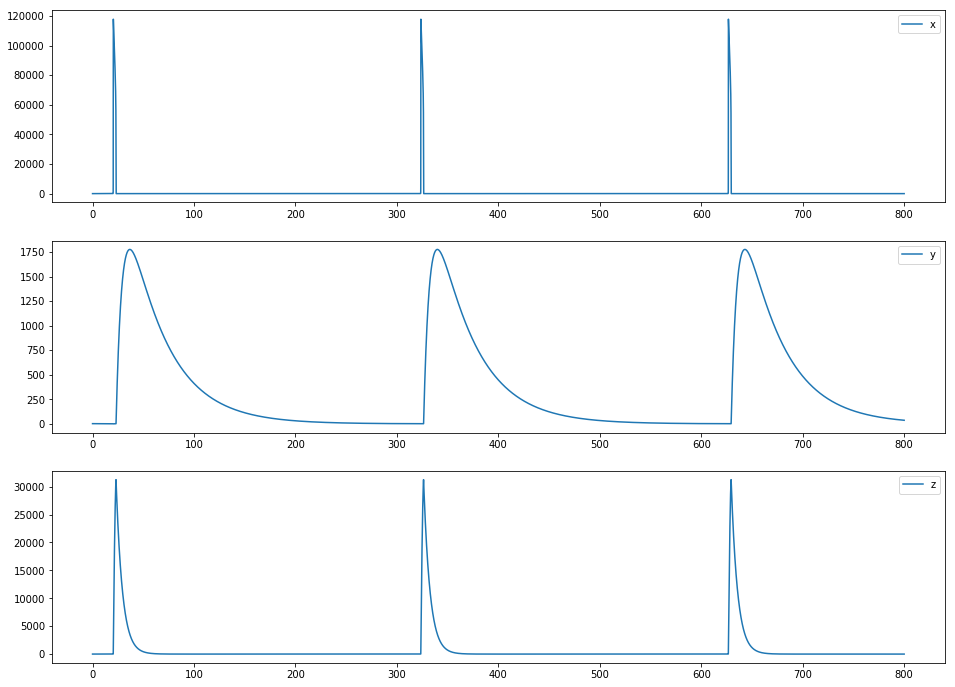

In [6]:
plt.figure(figsize=(16,12))
plt.subplot(311)
plt.plot(ts, xs, label='x');
plt.legend();
plt.subplot(312)
plt.plot(ts, ys, label='y');
plt.legend();
plt.subplot(313)
plt.plot(ts, zs, label='z');
plt.legend();

Сходимость по сетке была проверена при значениях шага 5e-5, 2e-5, 1e-5. Малое число точек обусловлено большой времезатратностью метода, поскольку при наибольшем шаге время подсчета составляет 10 минут. При шаге меньше 1e-4 метод не сходится, поскольку решение ведет себя иначе и периодические колебания компонент вектора $u$ не наблюдаются. 

### 2. Оценка погрешности метода по правилу Рунге

В момент времени $t=360$ оценим погрешность метода, используя правило Рунге. Выбор конкретно этого момента времени мотивирован наличием точного решения в данной точке, полученного в предыдущих решениях данной задачи. 

In [8]:
check_index = int(360 / h)
val_half_h = np.array([[xs[check_index], ys[check_index], zs[check_index]]]).T
print('Значение u при h = 1e-5:')
print(val_half_h)

Значение u при h = 1e-5:
[[1.00080343e+00]
 [1.24565265e+03]
 [1.43124882e+02]]


In [9]:
T = 800
h_doubled = 2*1e-5
n_doubled = int(T/h_doubled)
st_point = [1, 2, 3]
table_doubled = rkk_rank4(n_doubled, h_doubled, st_point)

xs_doubled = [unit[0] for unit in table_doubled]
ys_doubled = [unit[1] for unit in table_doubled]
zs_doubled = [unit[2] for unit in table_doubled]

In [10]:
check_index_doubled = int(360 / h_doubled)
val_h = np.array([[xs_doubled[check_index_doubled], ys_doubled[check_index_doubled], 
                   zs_doubled[check_index_doubled]]]).T
print('Значение u при h = 2e-5:')
print(val_h)

Значение u при h = 2e-5:
[[1.00080343e+00]
 [1.24565265e+03]
 [1.43124882e+02]]


По правилу Рунге для метода четвертого порядка имеем, что

$\textit{Error} = \frac{1}{15} \cdot |y_h(t_i) - y_{\frac{h}{2}}(t_i)|$

In [11]:
# абсолютная
method_error = abs(1/15 * (val_h - val_half_h))
method_error

array([[0.00000000e+00],
       [7.91260391e-12],
       [3.46934333e-12]])

In [12]:
# нормированная
np.array([[method_error[0]/val_h[0], method_error[1]/val_h[1], method_error[2]/val_h[2]]]).T

array([[[0.00000000e+00],
        [6.35217525e-15],
        [2.42399733e-14]]])

### 3. Оценка порядка вычислительной погрешности

Исследуем влиянии длины мантиссы на полученные результаты. До этого использовалась 64-битная архитектура, теперь проведем вычисления для 32-битной. Сравним полученные результаты. 

In [13]:
def f_32(u):
    y1, y2, y3 = list(map(np.float32, u))
    return [np.float32(77.27) * (y2 + y1 * (np.float32(1.0) - np.float32(8.375 * 1e-6) * y1 - y2)), 
            np.float32(1.0) / np.float32(77.27) * (y3 - (np.float32(1) + y1) * y2), 
            np.float32(0.16) * (y1 - y3)]

In [14]:
def rkk_rank4_32(n, h, st_point):
    point = list(map(np.float32, st_point))
    h = np.float32(h)
    res = [st_point]
    for i in range(n-1):
        k1 = f_32(point)
        k2_arg = [point[i] + np.float32(0.5)*h*k1[i] for i in range(len(point))]
        k2 = f_32(k2_arg)
        k3_arg = [point[i] + np.float32(0.5)*h*k2[i] for i in range(len(point))]
        k3 = f_32(k3_arg)
        k4_arg = [point[i] + h*k3[i] for i in range(len(point))]
        k4 = f_32(k4_arg)
        next_point = [point[i] + h/np.float32(6) * \
                      (k1[i]+np.float32(2)*k2[i]+np.float32(2)*k3[i]+k4[i]) for i in range(len(point))]
        res.append(next_point)
        point = next_point
    return res

In [15]:
T_32 = 800
h_32 = 1e-5
n_32 = int(T_32/h_32)
st_point = [1, 2, 3]
table_32 = rkk_rank4_32(n_32, h_32, st_point)

In [16]:
check_index_32 = int(360 / h_32)-1
print(np.array([table_doubled[check_index_32]]).T)

[[1.0007228e+00] <br/>
$\,$ [1.3844990e+03] <br/>
$\,$ [3.2084009e+02]]

Заметим, что во второй и третьей компоненте накоплена существенная ошибка по сравнению с 64-битной архитектурой мантиссы. То есть вычислительная погрешность вносит ощутимый вклад в итоговую погрешность. В частности, предположительно, этим можно объяснить частичное несовпадение результатов с эталоном, полученным в предыдущих работах с высокой точностью. 

In [17]:
comparison = [1.000814868842, 0.1228180744895*1e4, 0.1320568339839*1e3]
print(np.array([comparison]).T)

[[1.00081487e+00]
 [1.22818074e+03]
 [1.32056834e+02]]


In [18]:
xs_32 = [unit[0] for unit in table_32]
ys_32 = [unit[1] for unit in table_32]
zs_32 = [unit[2] for unit in table_32]

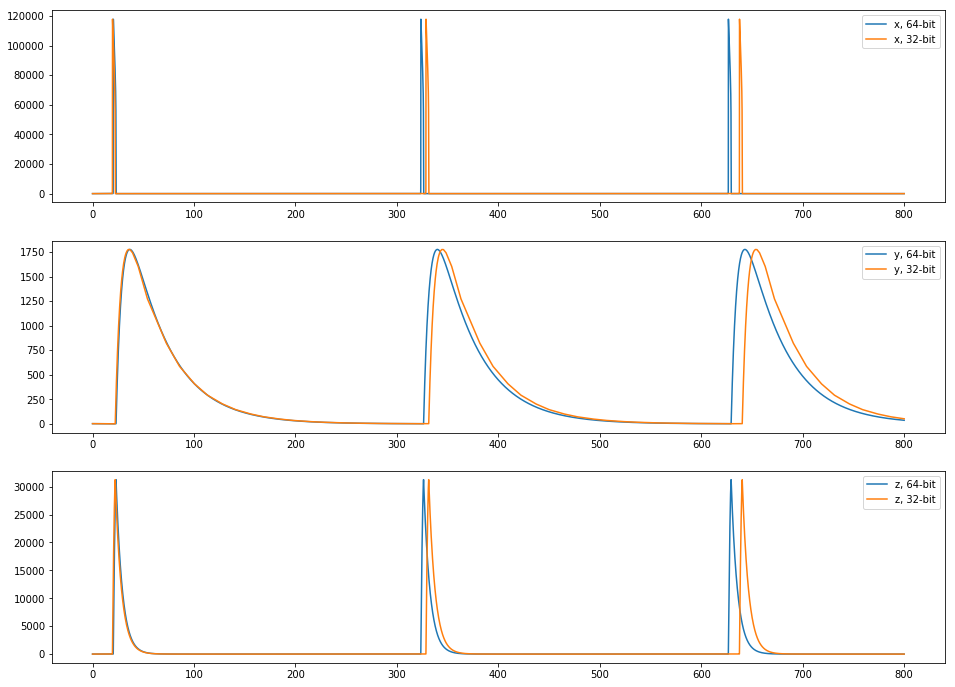

In [19]:
plt.figure(figsize=(16,12))
plt.subplot(311)
plt.plot(ts, xs, label='x, 64-bit');
plt.plot(ts, xs_32, label='x, 32-bit');
plt.legend();
plt.subplot(312)
plt.plot(ts, ys, label='y, 64-bit');
plt.plot(ts, ys_32, label='y, 32-bit');
plt.legend();
plt.subplot(313)
plt.plot(ts, zs, label='z, 64-bit');
plt.plot(ts, zs_32, label='z, 32-bit');
plt.legend();

Видим, что при уменьшении длины мантиссы график решения сдвигается вправо, что оправдывает погрешность полученную в нашей работе, поскольку точное решение взятое из предыдущих работ по этой теме было вычислено при 128-битной мантиссе, а для уменьшения времени вычислений в этой работе вычисления проводились на 64-битной мантиссе, что привело к сдвигу графика вправо по сравнению с интинным решением.

### 4.Неявный метод Рунге-Кутта(метод Хаммера-Холлинсворта)

In [3]:
def solver(k0, f, h, y):
    n = len(k0) // 2
    k1 = k0[n:]
    k2 = k0[:n]
    return np.concatenate((k1 - f(y + h / 4 * k1 + h * (1 / 4 - sqrt(3) / 6) * k2),
                           k2 - f(y + h / 4 * k2 + h * (1 / 4 + sqrt(3) / 6) * k1)))

def Hammer(n, f, st_point, h):
    point = st_point
    res = [point]
    for i in range(n-1):
        k = fsolve(solver, np.zeros(2 * point.size), (f, h, point))
        m = len(k) // 2
        k1 = k[m:]
        k2 = k[:m]
        point_new = point + (k1 + k2) / 2
        res.append(point_new)
        point = point_new
    return res

In [4]:
T = 800
h = 1e-5
n = int(T/h)
st_point = np.array([1, 2, 3])
table = Hammer(n, f, st_point, h)

In [5]:
ts = [i*h for i in range(n)]
xs = [unit[0] for unit in table]
ys = [unit[1] for unit in table]
zs = [unit[2] for unit in table]

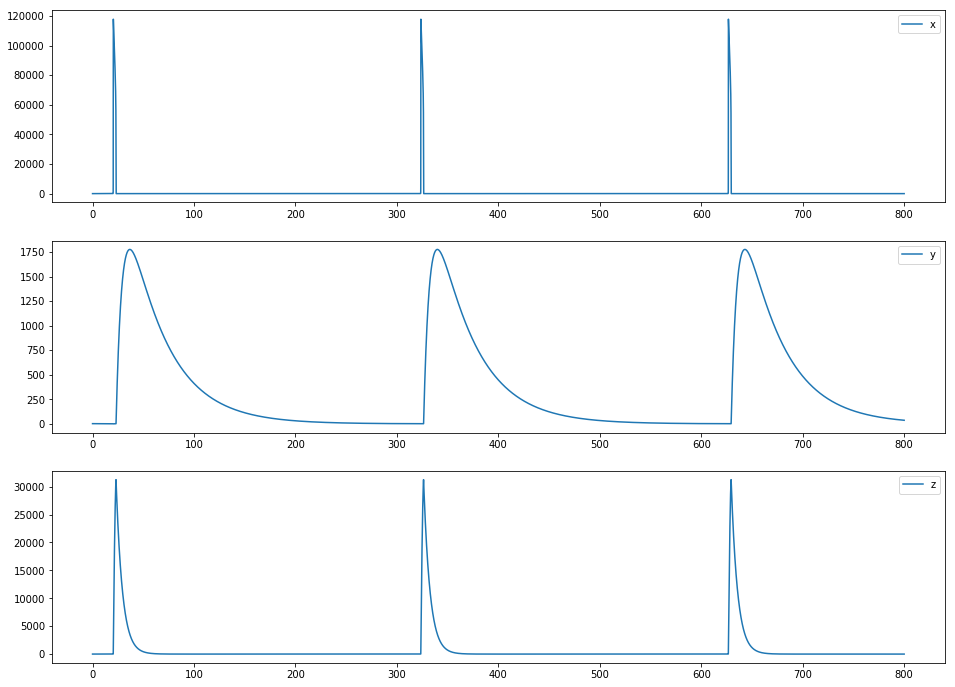

In [6]:
plt.figure(figsize=(16,12))
plt.subplot(311)
plt.plot(ts, xs, label='x');
plt.legend();
plt.subplot(312)
plt.plot(ts, ys, label='y');
plt.legend();
plt.subplot(313)
plt.plot(ts, zs, label='z');
plt.legend();

### 5.Вывод

Для решения  жесткой системы ОДУ химической кинетики использовались явный и неявный методы Рунге-Кутта 4-го порядка. Была исследована сходимость явного метода. Метод сходиться при значениях шага меньших $10^{-4}$. Получена погрешность метода и исследован вклад вычислительной погрешности в суммарную погрешность. Было выяснено, что полученная нами погрешность в основном состоит из вычислительной погрешности из-за ограничения длины мантиссы. Также реализован метод Хаммера-Холлинсворта. Сходимость метода исследовать не удалось из-за слишком большого времени выполнения метода при тех значениях шага, при которых наблюдается сходимость.